# Importing Libraries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', 45)

# Loading Data

In [2]:
folder_path = '/content/drive/MyDrive/Tennis_Analysis/full_matches_data'

# List all files in the directory with a .csv extension
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Use a list comprehension to read each file into a dataframe and then concatenate them all
combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in all_files], ignore_index=True)

In [ ]:
combined_df.sample(10)

# Understanding the Big Picture

In [4]:
number_of_rows = combined_df.shape[0]
number_of_columns = combined_df.shape[1]

print(f"The dataset has {number_of_rows} rows and {number_of_columns} columns.")

The dataset has 104682 rows and 49 columns.


In [ ]:
combined_df.info()

In [ ]:
combined_df.columns

Checking if there are any duplicate rows

In [7]:
number_of_duplicated_rows = combined_df.duplicated().sum()
print(f"There are {number_of_duplicated_rows} duplicated rows in the dataset.")

There are 0 duplicated rows in the dataset.


# Data Cleaning

Changing the format of the dates in the tourney_date column, from `YYYYMMDD` format to `Y M D` format.

In [ ]:
combined_df['tourney_date'] = pd.to_datetime(combined_df['tourney_date'], format='%Y%m%d')
combined_df.head()

Deleting unnecessary columns:

In [ ]:
names_of_columns_to_drop = ["winner_seed", "winner_entry", "loser_seed", "loser_entry"]

combined_df.drop(columns=["winner_seed", "winner_entry", "loser_seed", "loser_entry", "match_num"], inplace=True)

combined_df.columns

Creating new columns:

In [ ]:
combined_df["total_points"] = combined_df["w_svpt"]+combined_df["l_svpt"]
combined_df.sample(7)

# Univariate Analysis

## Categorical Variables

Counting the number of games played on each surface type (and plotting it):

In [ ]:
combined_df.surface.value_counts()

In [ ]:
plt.figure(figsize=(12,6))
surfaces_countplot = sns.countplot(data=combined_df, x="surface", order=combined_df.surface.value_counts().index)
surfaces_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')
surfaces_countplot.set_xlabel("Type of Surface")
surfaces_countplot.set_ylabel("Number of Matches Played")
surfaces_countplot.set_title("Number of Matches Played Between 1991 and 2023* on each surface")
plt.show()

Counting the number of times a best of 3 sets and a best of 5 sets were played (and plotting it):

In [ ]:
combined_df.best_of.value_counts()

In [ ]:
plt.figure(figsize=(12,6))
best_of_countplot = sns.countplot(data=combined_df, x="best_of", order=combined_df.best_of.value_counts().index)
best_of_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')
best_of_countplot.set_xlabel("Best of How Many Sets")
best_of_countplot.set_ylabel("Number of Matches")
best_of_countplot.set_title("Number of Matches Played Between 1991 and 2023")
plt.show()

In [ ]:
combined_df.winner_hand.value_counts()

In [ ]:
combined_df.loser_hand.value_counts()

## Numerical Variables

Analyzing the total_points variable:

In [31]:
combined_df.total_points.describe()

count    94475.000000
mean       159.096047
std         57.432572
min          1.000000
25%        116.000000
50%        148.000000
75%        191.000000
max        980.000000
Name: total_points, dtype: float64

AttributeError: ignored

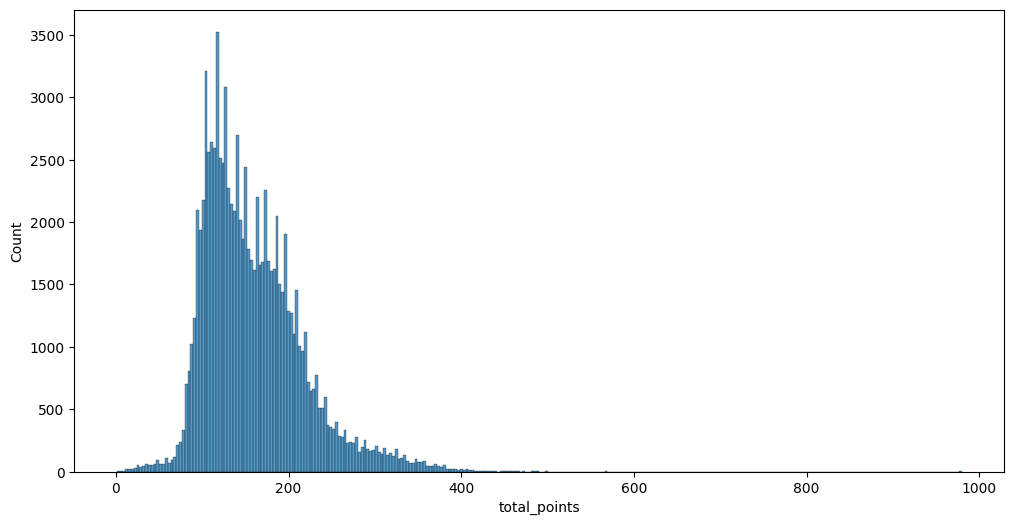

In [33]:
plt.figure(figsize=(12, 6))
total_point_histogram = sns.histplot(data=combined_df, x="total_points")
total_point_histogram.despine(left=True, bottom=True)
total_point_histogram.set_xlabel("Total Number of Points Played in a Match")
total_point_histogram.set_ylabel("Number of Matches")
plt.show()